In [ ]:
import pypyodbc as odbc
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import joblib
from sklearn.pipeline import Pipeline

ModuleNotFoundError: No module named 'catboost'

In [ ]:
# -----------------------------
# 1. Load data
# -----------------------------
DRIVER_NAME = 'SQL Server'
SERVER_NAME = 'HIMA'
DATABASE_NAME = 'ITIExaminationSystem'

CONNECTION_STRING = f'DRIVER={{{DRIVER_NAME}}};SERVER={SERVER_NAME};DATABASE={DATABASE_NAME};Trusted_Connection=yes;'
conn = odbc.connect(CONNECTION_STRING)

query = """
SELECT s.Student_ID, s.Student_Faculty, s.Student_Faculty_Grade,
       s.Student_Gender, s.Student_ITI_Status, s.Student_Marital_Status,
       SUM(sea.student_grade) AS total_grade,
       c.Company_Name
FROM Student AS s
LEFT JOIN Student_Company AS sc ON s.Student_ID = sc.Student_ID
LEFT JOIN Company AS c ON sc.Company_ID = c.Company_ID
INNER JOIN Student_Exam_Answer AS sea ON sea.Student_ID = s.Student_ID
WHERE sea.Exam_ID IN (SELECT Exam_ID FROM exam WHERE Exam_Type = 'Normal')
GROUP BY s.Student_ID, s.Student_Faculty, s.Student_Faculty_Grade,
         s.Student_Gender, s.Student_ITI_Status, s.Student_Marital_Status, c.Company_Name
"""
df = pd.read_sql(query, conn)


C:\Users\PC\AppData\Local\Temp\ipykernel_28132\265632298.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [19]:
# -----------------------------
# 2. Data Cleaning & Feature Engineering
# -----------------------------
df['company_name'].fillna('Unemployed', inplace=True)
df['student_faculty_grade'] = df['student_faculty_grade'].map({'Pass': 3, 'Good': 2, 'Very Good': 1, 'Excellent': 0})
df['student_iti_status'] = df['student_iti_status'].map({'Failed to Graduate': 1, 'Graduated': 0})
df['grade_bucket'] = pd.qcut(df['total_grade'], q=4, labels=['Low', 'Medium', 'High', 'Top'])
df['faculty_grade_combo'] = df['student_faculty'] + "_" + df['grade_bucket'].astype(str)

# Faculty groups
def faculty_group(faculty):
    stem = ['Faculty of Computers Sciences', 'Faculty of Engineering', 'Faculty of Information Systems', 'Faculty of Science']
    business = ['Faculty of Business Administration', 'Faculty of Commerce', 'Faculty of Economics and Political Science']
    arts = ['Faculty of Fine Arts', 'Faculty of Applied Arts', 'Faculty of Arts']
    applied = ['Faculty of Agriculture', 'Faculty of Education']
    if faculty in stem:
        return 'STEM'
    elif faculty in business:
        return 'Business'
    elif faculty in arts:
        return 'Arts'
    elif faculty in applied:
        return 'Applied'
    else:
        return 'Other'

df['faculty_group'] = df['student_faculty'].apply(faculty_group)

# Binary target
df['employed'] = df['company_name'].apply(lambda x: 0 if x == 'Unemployed' else 1)


C:\Users\PC\AppData\Local\Temp\ipykernel_28132\2125754579.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['company_name'].fillna('Unemployed', inplace=True)


In [20]:
# -----------------------------
# 3. Features and Categorical List
# -----------------------------
features = ['student_iti_status', 'total_grade', 'grade_bucket', 'student_faculty_grade']
categorical_features = ['grade_bucket']

X = df[features]
y = df['employed']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [21]:

# -----------------------------
# 4. CatBoost Binary Classifier
# -----------------------------

cat_model_tuned = CatBoostClassifier(
    iterations=2000,       # increase from 1000 to 2500
    depth=6,               # deeper trees
    learning_rate=0.05,    # smaller learning rate
    loss_function='Logloss',
    eval_metric='BalancedAccuracy',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50,
    class_weights=[1,2]    # balance employed/unemployed
)
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

start = time.time()
cat_model_tuned.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)
end = time.time()
print(f"⏱ CatBoost training completed in {end - start:.2f} seconds")


0:	learn: 0.5000000	test: 0.5000000	best: 0.5000000 (0)	total: 11.2ms	remaining: 22.3s
100:	learn: 0.5631148	test: 0.5485680	best: 0.5485680 (87)	total: 2.24s	remaining: 42.1s
200:	learn: 0.5672443	test: 0.5495898	best: 0.5495898 (181)	total: 4.58s	remaining: 41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5515239375
bestIteration = 212

Shrink model to first 213 iterations.
⏱ CatBoost training completed in 6.39 seconds


In [22]:

# -----------------------------
# 5. Evaluate
# -----------------------------
y_pred = cat_model_tuned.predict(X_test)

print("=== Binary Classification: Employed vs Unemployed (CatBoost) ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

=== Binary Classification: Employed vs Unemployed (CatBoost) ===
Accuracy: 0.6426356589147287
Balanced Accuracy: 0.5515239374867407
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      1790
           1       0.40      0.32      0.35       790

    accuracy                           0.64      2580
   macro avg       0.56      0.55      0.55      2580
weighted avg       0.62      0.64      0.63      2580



                 Feature  Importance
0     student_iti_status   89.519023
1            total_grade    5.332933
3  student_faculty_grade    4.404461
2           grade_bucket    0.743583


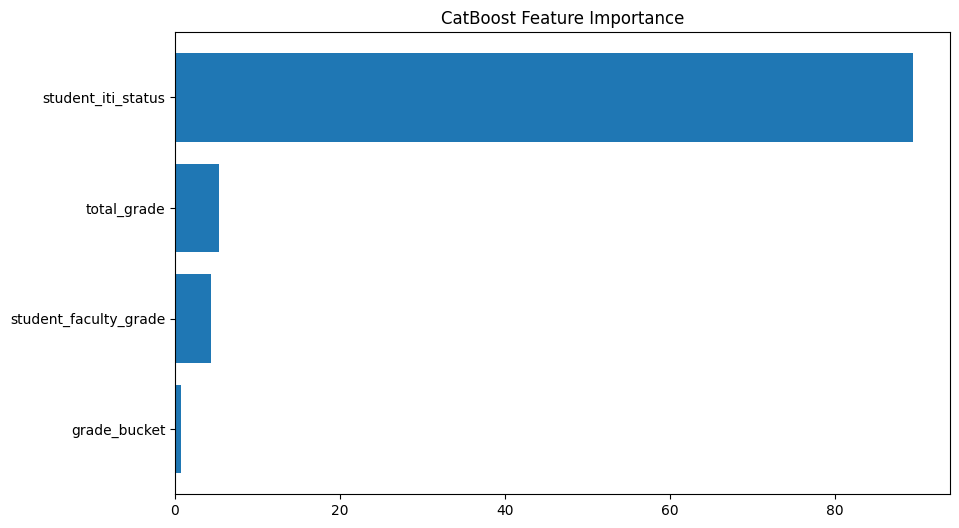

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

feature_importances = cat_model_tuned.get_feature_importance(train_pool)
feature_names = X_train.columns

fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

print(fi_df)

# Optional: plot
plt.figure(figsize=(10,6))
plt.barh(fi_df['Feature'], fi_df['Importance'])
plt.gca().invert_yaxis()
plt.title('CatBoost Feature Importance')
plt.show()

In [24]:
cat_model_tuned.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)
cat_model_tuned.save_model("catboost_employment_model.cbm")
joblib.dump(cat_model_tuned, "catboost_employment_model.pkl")

0:	learn: 0.5000000	test: 0.5000000	best: 0.5000000 (0)	total: 10.6ms	remaining: 21.2s
100:	learn: 0.5631148	test: 0.5485680	best: 0.5485680 (87)	total: 2.17s	remaining: 40.9s
200:	learn: 0.5672443	test: 0.5495898	best: 0.5495898 (181)	total: 4.33s	remaining: 38.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5515239375
bestIteration = 212

Shrink model to first 213 iterations.


['catboost_employment_model.pkl']